## Overview

This notebook demonstrates advanced techniques for enhancing linear regression models by incorporating:
- **Interaction terms** between variables
- **Qualitative (categorical) predictors** 
- **Polynomial transformations**
- **Mixed interactions** between categorical and continuous variables

**Prerequisites:** Read sections 3.3.1 and 3.3.2 of the textbook before using these notes.

**Note:** These notes focus on practical implementation. The textbook provides the theoretical foundation.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import warnings

# Configuration
pd.set_option('display.float_format', '{:.2f}'.format)
np.random.seed(42)  # For reproducibility
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (10, 6)
warnings.filterwarnings('ignore')

## Learning Objectives

By the end of this notebook, you should be able to:

### Core Concepts
- ✅ **Understand** when and why to use interaction terms in regression models
- ✅ **Interpret** coefficients in models with interactions
- ✅ **Apply** different encoding strategies for categorical predictors

### Technical Skills  
- ✅ **Implement** interaction terms using both `statsmodels` and `sklearn`
- ✅ **Use** `PolynomialFeatures` to generate polynomial and interaction terms
- ✅ **Handle** categorical variables with `OneHotEncoder` and `get_dummies`
- ✅ **Create** robust preprocessing pipelines with `ColumnTransformer`

### Advanced Applications
- ✅ **Model** complex relationships between qualitative and continuous predictors
- ✅ **Apply** polynomial transformations to capture non-linear patterns
- ✅ **Evaluate** and compare different model specifications
- ✅ **Avoid** common pitfalls like data leakage and multicollinearity

## Dataset

- Training set: `Datasets/Car_features_train.csv`, `Datasets/Car_prices_train.csv`
- Test set: `Datasets/Car_features_test.csv`, `Datasets/Car_prices_test.csv`

We replace `year` with `age`, computed as `reference_year - year`, where `reference_year` is the most recent model year in the training data.


In [3]:
# Read data
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')

train = pd.merge(trainf, trainp)
test = pd.merge(testf, testp)

# Create age feature using the most recent model year in the training data
reference_year = train["year"].max()
train["age"] = reference_year - train["year"]
test["age"] = reference_year - test["year"]

train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price,age
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.33,3.00,37980,0
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.04,3.00,33980,1
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.44,3.00,36850,0
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.51,3.00,25998,3
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.49,3.00,18990,5


## Part 1: Working with statsmodels

### Interaction Terms (Continuous Variables)

#### The Problem with Additive Models
In a standard linear model: `price = β₀ + β₁×age + β₂×engineSize + ε`

This assumes the effect of `engineSize` on `price` is **constant** regardless of the car's `age`. But what if:
- Larger engines depreciate faster with age?
- The value premium for larger engines changes over time?

#### Solution: Add an Interaction Term
We relax the constant-association assumption by adding an interaction between `engineSize` and `age`:

`price = β₀ + β₁×age + β₂×engineSize + β₃×(age × engineSize) + ε`

Now the effect of `engineSize` depends on `age`, and vice versa.

In [5]:
# Fit model with interaction between engineSize and age
# The '*' operator creates both main effects and their interaction
model_sm_interaction = smf.ols(
    formula='price ~ age*engineSize + mileage + mpg',
    data=train,
).fit()

model_sm_interaction.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     2121.
Date:                Fri, 23 Jan 2026   Prob (F-statistic):               0.00
Time:                        08:15:24   Log-Likelihood:                -52338.
No. Observations:                4960   AIC:                         1.047e+05
Df Residuals:                    4954   BIC:                         1.047e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       4313.7409    804.871      5.360      0.000    2735.838    5891.644
age              275.3833    135.695      2.029      0.042       9.361     541.405
engineSize       1.52e+04    248.298     61.231      0.000    1.47e+04    1.57e+04
age:engineSize  -896.7687     49.431    -18.142      0.000    -993.676    -799.861
mileage           -0.1525      0.008    -17.954      0.000      -0.169      -0.136
mpg              -84.3417      9.048     -9.322      0.000    -102.079     -66.604
==============================================================================
Omnibus:                     2330.413   Durbin-Watson:                   0.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29977.437
Skew:                           1.908   Prob(JB):                         0.00
Kurtosis:                      14.423   Cond. No.                     2.22e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Understanding the Interaction Model

The complete model equation is:
$$\text{price} = \beta_0 + \beta_1 \cdot \text{age} + \beta_2 \cdot \text{engineSize} + \beta_3 \cdot (\text{age} \times \text{engineSize}) + \beta_4 \cdot \text{mileage} + \beta_5 \cdot \text{mpg}$$

#### Key Insights:

**1. The effect of `engineSize` on price now depends on `age`:**
   - For a car of age $t$: $\frac{\partial \text{price}}{\partial \text{engineSize}} = \beta_2 + \beta_3 \cdot t$
   
**2. The effect of `age` on price depends on `engineSize`:**
   - For a car with engine size $s$: $\frac{\partial \text{price}}{\partial \text{age}} = \beta_1 + \beta_3 \cdot s$

**3. Interpretation of β₃ (interaction coefficient):**
   - How much the effect of engine size changes for each additional year of age
   - How much the effect of age changes for each additional liter of engine size

In [6]:
# Evaluate model performance on test data
pred_price = model_sm_interaction.predict(test)
rmse_interaction = np.sqrt(((test.price - pred_price) ** 2).mean())
mae_interaction = np.mean(np.abs(test.price - pred_price))
r2_interaction = 1 - np.sum((test.price - pred_price)**2) / np.sum((test.price - np.mean(test.price))**2)

print("Model Performance on Test Set:")
print("=" * 40)
print(f"RMSE: ${rmse_interaction:,.2f}")
print(f"MAE:  ${mae_interaction:,.2f}")
print(f"R²:   {r2_interaction:.4f}")

# Store results for later comparison
interaction_results = {
    'RMSE': rmse_interaction,
    'MAE': mae_interaction,
    'R2': r2_interaction
}

Model Performance on Test Set:
RMSE: $9,423.60
MAE:  $6,140.26
R²:   0.6776


#### Key Takeaway: The Bias-Variance Trade-off

**Benefits of Interaction Terms:**

- ✅ Capture complex, realistic relationships between variables
- ✅ Improve model flexibility and potentially better fit
- ✅ Allow effects to vary contextually

**Potential Drawbacks:**

- ⚠️ Increased model complexity → higher variance
- ⚠️ Risk of overfitting, especially with limited data
- ⚠️ More difficult to interpret
- ⚠️ Require larger sample sizes for reliable estimation

**Best Practice:** Always validate interaction terms using cross-validation or hold-out data! (will be covered later)

### Qualitative (Categorical) Predictors

#### Understanding Categorical Variables in Regression

When we include a categorical variable in regression, we need to convert it to numerical form. The most common approach is **dummy coding** (also called one-hot encoding).

#### Example: Transmission Type
Let's develop a model predicting `price` based on `engineSize` and the categorical variable `transmission`.

In [7]:
# Explore the categorical variable
print("Transmission Type Distribution:")
print("=" * 40)
transmission_counts = train.transmission.value_counts()
print(transmission_counts)

Transmission Type Distribution:
transmission
Manual       1948
Automatic    1660
Semi-Auto    1351
Other           1
Name: count, dtype: int64


#### Handling Rare Categories

The **Other** category has very few observations (< 1% of data). This can cause issues:

- **Unreliable estimates** due to small sample size
- **Overfitting** risk
- **Unstable predictions** on new data

**Common Solutions:**
1. **Remove** the rare category (what we'll do here)
2. **Combine** with the most similar category
3. **Create** a "Rare" category grouping multiple small categories

In [9]:
# Remove the rare 'Other' category
train_updated = train[train.transmission != 'Other'].copy()

print(f"\nUpdated distribution:")
print(train_updated.transmission.value_counts())


Updated distribution:
transmission
Manual       1948
Automatic    1660
Semi-Auto    1351
Name: count, dtype: int64


In [11]:
# Fit model with categorical predictor
# statsmodels automatically creates dummy variables
model_sm_trans = smf.ols(
    formula='price ~ engineSize + transmission',
    data=train_updated,
).fit()

print("Model with Categorical Predictor:")
print("=" * 50)
model_sm_trans.summary()


Model with Categorical Predictor:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     1400.
Date:                Fri, 23 Jan 2026   Prob (F-statistic):               0.00
Time:                        08:16:23   Log-Likelihood:                -53644.
No. Observations:                4959   AIC:                         1.073e+05
Df Residuals:                    4955   BIC:                         1.073e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  3042.6765    661.190      4.602      0.000    1746.451    4338.902
transmission[T.Manual]    -6770.6165    442.116    -15.314      0.000   -7637.360   -5903.873
transmission[T.Semi-Auto]  4994.3112    442.989     11.274      0.000    4125.857    5862.765
engineSize                 1.023e+04    247.485     41.323      0.000    9741.581    1.07e+04
==============================================================================
Omnibus:                     1575.518   Durbin-Watson:                   0.579
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11006.609
Skew:                           1.334   Prob(JB):                         0.00
Kurtosis:                       9.793   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Understanding Dummy Variable Encoding

**Key Concepts:**

1. **Reference Category (Baseline):** The category that's omitted to avoid perfect multicollinearity
   - Here: "Automatic" (chosen alphabetically by default)
   - All other coefficients are interpreted **relative to this baseline**

2. **Coefficient Interpretation:**
   - `transmission[T.Manual]`: How much Manual cars cost **compared to Automatic cars**, holding engine size constant
   - `transmission[T.Semi-Auto]`: How much Semi-Auto cars cost **compared to Automatic cars**, holding engine size constant

3. **Why Drop One Category?**
   - With k categories, we only need k-1 dummy variables
   - Including all k would create perfect multicollinearity (dummy trap)

**Q:** Interpret the intercept term.

**A:** For a hypothetical car with zero engine size and *Automatic* transmission, the estimated mean price is the intercept.


**Q:** Interpret the coefficient of `transmission[T.Manual]`.

**A:** Holding engine size fixed, the estimated mean price of a manual car differs from an automatic car by that coefficient.


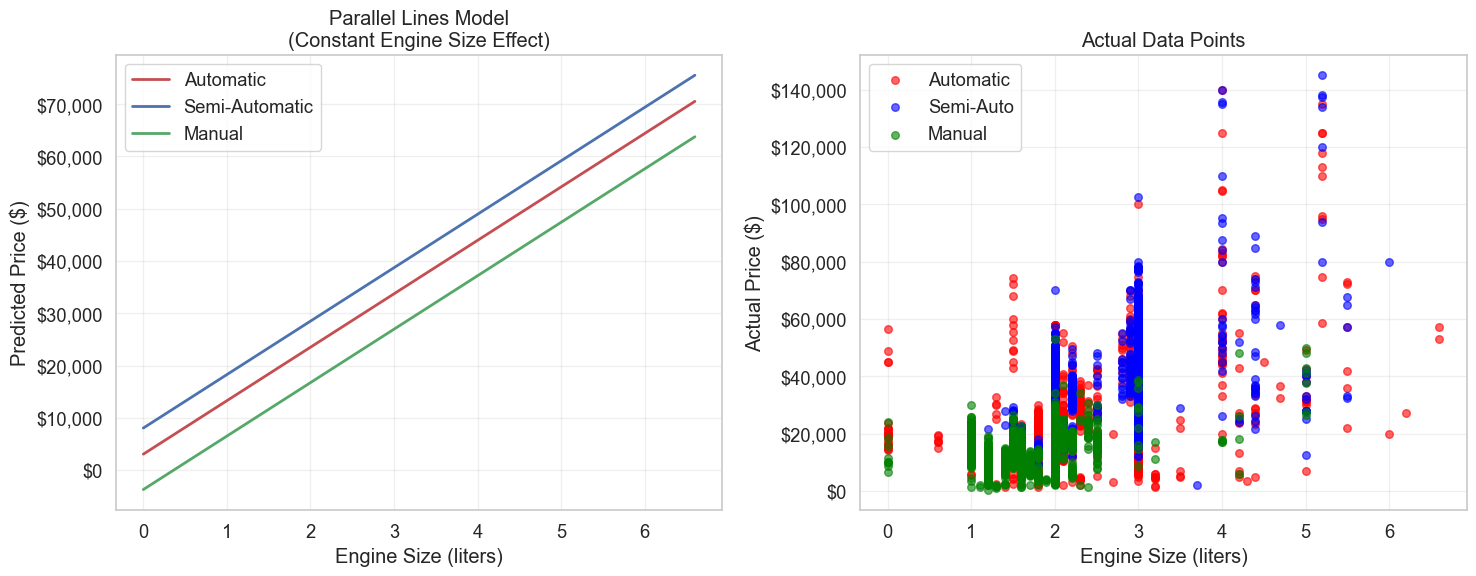

📊 Model Assumption: Parallel lines indicate that the effect of engine size
   is the same across all transmission types (additive model).


In [12]:
# Visualize the model with parallel lines
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Model predictions
x = np.linspace(train_updated.engineSize.min(), train_updated.engineSize.max(), 100)
params = model_sm_trans.params

# Calculate predictions for each transmission type
auto_pred = params['engineSize'] * x + params['Intercept']
manual_pred = params['engineSize'] * x + params['Intercept'] + params['transmission[T.Manual]']
semi_pred = params['engineSize'] * x + params['Intercept'] + params['transmission[T.Semi-Auto]']

ax1.plot(x, auto_pred, 'r-', linewidth=2, label='Automatic')
ax1.plot(x, semi_pred, 'b-', linewidth=2, label='Semi-Automatic')
ax1.plot(x, manual_pred, 'g-', linewidth=2, label='Manual')

ax1.legend()
ax1.set_xlabel('Engine Size (liters)')
ax1.set_ylabel('Predicted Price ($)')
ax1.set_title('Parallel Lines Model\n(Constant Engine Size Effect)')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax1.grid(True, alpha=0.3)

# Plot 2: Actual data points
for i, transmission in enumerate(['Automatic', 'Semi-Auto', 'Manual']):
    data = train_updated[train_updated.transmission == transmission]
    colors = ['red', 'blue', 'green']
    ax2.scatter(data.engineSize, data.price, 
               alpha=0.6, s=30, c=colors[i], label=transmission)

ax2.set_xlabel('Engine Size (liters)')
ax2.set_ylabel('Actual Price ($)')
ax2.set_title('Actual Data Points')
ax2.legend()
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Model Assumption: Parallel lines indicate that the effect of engine size")
print("   is the same across all transmission types (additive model).")

### Interactions Between Categorical and Continuous Variables

#### Problem with Parallel Lines
The model above assumes the effect of engine size is **identical** across transmission types (parallel lines). But what if:

- **Manual cars** lose value differently with engine size than automatics?
- **Sports cars** (often manual) command higher premiums for large engines?
- **Different transmission types** have different market dynamics?

#### Solution: Add Interaction Terms
We can relax the parallel lines assumption by adding interactions between `engineSize` and `transmission`.

In [14]:
# Fit model with interaction between continuous and categorical variables
# The '*' creates main effects AND interaction terms
model_sm_trans_inter = smf.ols(
    formula='price ~ engineSize*transmission',
    data=train_updated,
).fit()

print("Model with Categorical-Continuous Interaction:")
print("=" * 55)
model_sm_trans_inter.summary()


Model with Categorical-Continuous Interaction:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     909.9
Date:                Fri, 23 Jan 2026   Prob (F-statistic):               0.00
Time:                        08:17:28   Log-Likelihood:                -53550.
No. Observations:                4959   AIC:                         1.071e+05
Df Residuals:                    4953   BIC:                         1.072e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             3754.7238    895.221      4.194      0.000    1999.695    5509.753
transmission[T.Manual]                1768.5856   1294.071      1.367      0.172    -768.366    4305.538
transmission[T.Semi-Auto]            -5282.7164   1416.472     -3.729      0.000   -8059.628   -2505.805
engineSize                            9928.6082    354.511     28.006      0.000    9233.610    1.06e+04
engineSize:transmission[T.Manual]    -5285.9059    646.175     -8.180      0.000   -6552.695   -4019.117
engineSize:transmission[T.Semi-Auto]  4162.2428    552.597      7.532      0.000    3078.908    5245.578
==============================================================================
Omnibus:                     1379.846   Durbin-Watson:                   0.622
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9799.471
Skew:                           1.139   Prob(JB):                         0.00
Kurtosis:                       9.499   Cond. No.                         30.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Q:** Interpret the coefficient of `transmission[T.Manual]`.

**A:** It shifts the intercept for manual cars relative to automatic cars.

**Q:** Interpret the coefficient of `engineSize:transmission[T.Manual]`.

**A:** It adjusts the slope of engine size for manual cars relative to automatic cars.


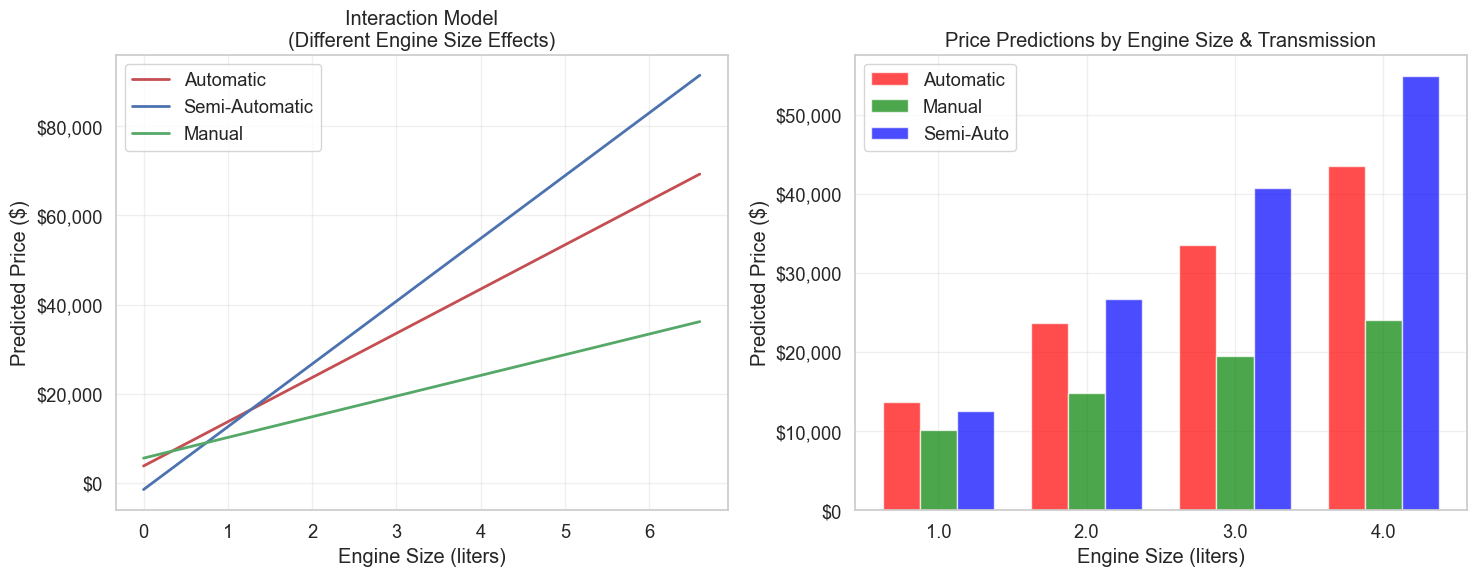

In [18]:
# Visualize the interaction model (non-parallel lines)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Model with interactions (non-parallel lines)
x = np.linspace(train_updated.engineSize.min(), train_updated.engineSize.max(), 100)
params = model_sm_trans_inter.params

# Calculate predictions for each transmission type (now with different slopes!)
auto_pred = params['engineSize'] * x + params['Intercept']

manual_pred = ((params['engineSize'] + params['engineSize:transmission[T.Manual]']) * x + 
               params['Intercept'] + params['transmission[T.Manual]'])

semi_pred = ((params['engineSize'] + params['engineSize:transmission[T.Semi-Auto]']) * x + 
             params['Intercept'] + params['transmission[T.Semi-Auto]'])

ax1.plot(x, auto_pred, 'r-', linewidth=2, label='Automatic')
ax1.plot(x, semi_pred, 'b-', linewidth=2, label='Semi-Automatic') 
ax1.plot(x, manual_pred, 'g-', linewidth=2, label='Manual')

ax1.legend()
ax1.set_xlabel('Engine Size (liters)')
ax1.set_ylabel('Predicted Price ($)')
ax1.set_title('Interaction Model\n(Different Engine Size Effects)')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax1.grid(True, alpha=0.3)

# Plot 2: Comparison of models at specific engine sizes
engine_sizes = [1.0, 2.0, 3.0, 4.0]
transmission_types = ['Automatic', 'Manual', 'Semi-Auto']
colors = ['red', 'green', 'blue']

x_pos = np.arange(len(engine_sizes))
width = 0.25

for i, trans_type in enumerate(['Automatic', 'Manual', 'Semi-Auto']):
    if trans_type == 'Automatic':
        pred_values = [params['engineSize'] * es + params['Intercept'] for es in engine_sizes]
    elif trans_type == 'Manual':
        pred_values = [((params['engineSize'] + params['engineSize:transmission[T.Manual]']) * es + 
                       params['Intercept'] + params['transmission[T.Manual]']) for es in engine_sizes]
    else:  # Semi-Auto
        pred_values = [((params['engineSize'] + params['engineSize:transmission[T.Semi-Auto]']) * es + 
                       params['Intercept'] + params['transmission[T.Semi-Auto]']) for es in engine_sizes]
    
    ax2.bar(x_pos + i*width, pred_values, width, label=trans_type, color=colors[i], alpha=0.7)

ax2.set_xlabel('Engine Size (liters)')
ax2.set_ylabel('Predicted Price ($)')
ax2.set_title('Price Predictions by Engine Size & Transmission')
ax2.set_xticks(x_pos + width)
ax2.set_xticklabels(engine_sizes)
ax2.legend()
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Calculate and display model performance
# Handle potential missing categories in test data first (before prediction)
test_filtered = test[test.transmission.isin(['Automatic', 'Manual', 'Semi-Auto'])].copy()
pred_interaction_filtered = model_sm_trans_inter.predict(test_filtered)

rmse_trans_inter = np.sqrt(((test_filtered.price - pred_interaction_filtered) ** 2).mean())
mae_trans_inter = np.mean(np.abs(test_filtered.price - pred_interaction_filtered))
r2_trans_inter = 1 - np.sum((test_filtered.price - pred_interaction_filtered)**2) / np.sum((test_filtered.price - np.mean(test_filtered.price))**2)

print(f"\n📈 Model Performance:")
print("=" * 40)
print(f"RMSE: ${rmse_trans_inter:,.2f}")
print(f"MAE:  ${mae_trans_inter:,.2f}")
print(f"R²:   {r2_trans_inter:.4f}")

# Note about filtered data
print(f"\nNote: Evaluated on {len(test_filtered)} test samples")
print(f"      (excluded {len(test) - len(test_filtered)} samples with 'Other' transmission)")


📈 Model Performance:
RMSE: $11,847.59
MAE:  $8,342.65
R²:   0.4906

Note: Evaluated on 2671 test samples
      (excluded 1 samples with 'Other' transmission)


## Part 2: Working with scikit-learn


In [21]:
# Prepare data for scikit-learn
print("🔧 Preparing Data for Scikit-Learn")

# Select features and target
feature_columns = ['mileage', 'engineSize', 'age', 'mpg']
X_train = train[feature_columns].copy()
y_train = train['price'].copy()
X_test = test[feature_columns].copy() 
y_test = test['price'].copy()


🔧 Preparing Data for Scikit-Learn


### Generating Interaction Terms with PolynomialFeatures

#### Understanding PolynomialFeatures

The `PolynomialFeatures` transformer is incredibly versatile:

**Key Parameters:**
- `degree`: Maximum degree of polynomial features
- `interaction_only`: If True, only interaction terms (no x²)
- `include_bias`: Whether to include intercept column

**Example with 2 features [x₁, x₂]:**

| Setting | Output Features |
|---------|----------------|
| `degree=1` | [x₁, x₂] |
| `degree=2, interaction_only=False` | [x₁, x₂, x₁², x₁x₂, x₂²] |
| `degree=2, interaction_only=True` | [x₁, x₂, x₁x₂] |

In [23]:
# Generate interaction-only features (no squared terms)
print("Creating Interaction-Only Features")
print("=" * 45)

poly_inter = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

# Fit on training data and transform both sets
X_train_inter = poly_inter.fit_transform(X_train)
X_test_inter = poly_inter.transform(X_test)

# Display the transformation
print(f"Original features: {X_train.shape[1]}")
print(f"After interaction features: {X_train_inter.shape[1]}")
print(f"Added interaction terms: {X_train_inter.shape[1] - X_train.shape[1]}")

print(f"\nFeature names:")
feature_names = poly_inter.get_feature_names_out(input_features=X_train.columns)
for i, name in enumerate(feature_names):
    marker = " (interaction)" if " " in name else " (original)"
    print(f"  {i+1:2d}. {name}{marker}")

# Train model with interactions
model_inter = LinearRegression()
model_inter.fit(X_train_inter, y_train)

# Evaluate performance
pred_price_inter = model_inter.predict(X_test_inter)
rmse_inter = root_mean_squared_error(y_test, pred_price_inter)
mae_inter = mean_absolute_error(y_test, pred_price_inter)
r2_inter = r2_score(y_test, pred_price_inter)

print(f"\n📊 Model Performance (Interaction-Only):")
print("=" * 45)
print(f"RMSE: ${rmse_inter:,.2f}")
print(f"MAE:  ${mae_inter:,.2f}")
print(f"R²:   {r2_inter:.4f}")


Creating Interaction-Only Features
Original features: 4
After interaction features: 10
Added interaction terms: 6

Feature names:
   1. mileage (original)
   2. engineSize (original)
   3. age (original)
   4. mpg (original)
   5. mileage engineSize (interaction)
   6. mileage age (interaction)
   7. mileage mpg (interaction)
   8. engineSize age (interaction)
   9. engineSize mpg (interaction)
  10. age mpg (interaction)

📊 Model Performance (Interaction-Only):
RMSE: $8,729.91
MAE:  $5,400.07
R²:   0.7234


### Full Polynomial Features (Including Squared Terms)

### Limitations of PolynomialFeatures

⚠️ **Key Limitation**: Unlike `statsmodels`, `PolynomialFeatures` applies transformations to **ALL** features:
- ✅ **Advantage**: Quick, systematic feature generation
- ❌ **Disadvantage**: No selective control over which interactions to include
- ❌ **Risk**: Can create too many features with high-dimensional data

**Trade-off**: Convenience vs. Control

Let's compare interaction-only vs. full polynomial features:

In [24]:
# Generate full polynomial features (includes squared terms)
print("Creating Full Polynomial Features (degree=2)")
print("=" * 55)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"After polynomial features: {X_train_poly.shape[1]}")
print(f"Added features: {X_train_poly.shape[1] - X_train.shape[1]}")

print(f"\nAll generated features:")
feature_names_poly = poly.get_feature_names_out(input_features=X_train.columns)
for i, name in enumerate(feature_names_poly):
    if "^2" in name:
        marker = " (squared)"
    elif " " in name:
        marker = " (interaction)"  
    else:
        marker = " (original)"
    print(f"  {i+1:2d}. {name}{marker}")

Creating Full Polynomial Features (degree=2)
Original features: 4
After polynomial features: 14
Added features: 10

All generated features:
   1. mileage (original)
   2. engineSize (original)
   3. age (original)
   4. mpg (original)
   5. mileage^2 (squared)
   6. mileage engineSize (interaction)
   7. mileage age (interaction)
   8. mileage mpg (interaction)
   9. engineSize^2 (squared)
  10. engineSize age (interaction)
  11. engineSize mpg (interaction)
  12. age^2 (squared)
  13. age mpg (interaction)
  14. mpg^2 (squared)


In [25]:
# Train model with full polynomial features
print("Training Full Polynomial Model")
print("=" * 40)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Show the most important coefficients
coeffs = model_poly.coef_
feature_importance = pd.DataFrame({
    'Feature': feature_names_poly,
    'Coefficient': coeffs,
    'Abs_Coefficient': np.abs(coeffs)
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 10 Most Important Features:")
display(feature_importance.head(10))

Training Full Polynomial Model
Top 10 Most Important Features:


,Feature,Coefficient,Abs_Coefficient
1,engineSize,22746.56,22746.56
2,age,-3022.42,3022.42
9,engineSize age,-644.88,644.88
8,engineSize^2,-361.71,361.71
10,engineSize mpg,-136.77,136.77
11,age^2,104.62,104.62
3,mpg,39.42,39.42
12,age mpg,16.68,16.68
13,mpg^2,0.66,0.66
0,mileage,-0.10,0.10


In [28]:
# Evaluate and compare polynomial models
pred_poly = model_poly.predict(X_test_poly)

# Calculate metrics for full polynomial model
rmse_poly = root_mean_squared_error(y_test, pred_poly)
mae_poly = mean_absolute_error(y_test, pred_poly)
r2_poly = r2_score(y_test, pred_poly)

print("📊 Model Performance Comparison")
print("=" * 45)

# Cross-validation for full polynomial
cv_scores_poly = cross_val_score(
    LinearRegression(), X_train_poly, y_train, 
    cv=5, scoring='neg_root_mean_squared_error'
)

# Create comprehensive comparison
results_df = pd.DataFrame({
    'Model': [
        'Baseline (Linear)', 
        'Interaction-Only',
        'Full Polynomial (degree=2)'
    ],
    'Features': [
        X_train.shape[1],
        X_train_inter.shape[1], 
        X_train_poly.shape[1]
    ],
    'Test_RMSE': [
        np.nan,  # We'll calculate baseline
        rmse_inter,
        rmse_poly
    ],
    'Test_MAE': [
        np.nan,
        mae_inter, 
        mae_poly
    ],
    'Test_R2': [
        np.nan,
        r2_inter,
        r2_poly
    ]

})

# Calculate baseline model for comparison
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)


# Update baseline results
results_df.loc[0, 'Test_RMSE'] = root_mean_squared_error(y_test, baseline_pred)
results_df.loc[0, 'Test_MAE'] = mean_absolute_error(y_test, baseline_pred)
results_df.loc[0, 'Test_R2'] = r2_score(y_test, baseline_pred)


display(results_df.round(4))

📊 Model Performance Comparison


,Model,Features,Test_RMSE,Test_MAE,Test_R2
0,Baseline (Linear),4,9956.83,6407.74,0.64
1,Interaction-Only,10,8729.91,5400.07,0.72
2,Full Polynomial (degree=2),14,8896.17,5335.30,0.71


## Part 3: Categorical Variables in Scikit-Learn

Scikit-learn models require **numerical input**. We need to convert categorical variables to numbers.

### Two Main Approaches:

| Method | Pros | Cons | Best For |
|--------|------|------|----------|
| **`pd.get_dummies()`** | Simple, intuitive | Column mismatch risk, no pipeline integration | Quick prototyping |
| **`OneHotEncoder`** | Robust, handles unseen categories, pipeline-friendly | Slightly more setup | Production code |

### Common Pitfalls:
❌ **Data Leakage**: Fitting encoder on full dataset  
❌ **Column Mismatch**: Train/test having different categories  
❌ **Dummy Trap**: Including all dummy variables → multicollinearity

### Method 1: Using `pd.get_dummies()`

#### ⚠️ The Column Alignment Problem

When using `get_dummies()`, train and test sets might have different categorical values:

```python
# Train has: ['A', 'B', 'C'] → columns: ['B', 'C'] (A is reference)
# Test has: ['A', 'B', 'D'] → columns: ['B', 'D'] (A is reference) 
# Result: Mismatched feature matrices! 🚨
```

**Solution**: Use `reindex()` to align columns.

In [29]:
# Method 1: get_dummies approach
print("🔧 Method 1: Using pd.get_dummies()")
print("=" * 45)

# Create dummy variables (watch for potential mismatched columns)
train_dum = pd.get_dummies(train_updated, columns=['transmission'], drop_first=True, prefix='trans')
test_dum = pd.get_dummies(test, columns=['transmission'], drop_first=True, prefix='trans')

print("Original column alignment:")
print(f"Train dummy columns: {[col for col in train_dum.columns if 'trans_' in col]}")
print(f"Test dummy columns:  {[col for col in test_dum.columns if 'trans_' in col]}")

# Critical step: Align test columns to match training columns
test_dum = test_dum.reindex(columns=train_dum.columns, fill_value=0)

print(f"\nAfter reindexing:")
print(f"Train shape: {train_dum.shape}")
print(f"Test shape:  {test_dum.shape}")
print(f"Columns match: {list(train_dum.columns) == list(test_dum.columns)}")

# Prepare feature matrices
feature_cols = ['engineSize', 'trans_Manual', 'trans_Semi-Auto']
X_train_dum = train_dum[feature_cols]
y_train_dum = train_dum['price']
X_test_dum = test_dum[feature_cols]
y_test_dum = test_dum['price']

print(f"\nFinal feature matrix:")
display(X_train_dum.head())

# Train and evaluate model
model_dum = LinearRegression()
model_dum.fit(X_train_dum, y_train_dum)
pred_dum = model_dum.predict(X_test_dum)
rmse_dum = root_mean_squared_error(y_test_dum, pred_dum)

print(f"\n📊 Performance:")
print(f"RMSE: ${rmse_dum:,.2f}")

# Show coefficients with interpretation
coeffs_dum = pd.DataFrame({
    'Feature': X_train_dum.columns,
    'Coefficient': model_dum.coef_
})
print(f"\nModel Coefficients:")
display(coeffs_dum)

🔧 Method 1: Using pd.get_dummies()
Original column alignment:
Train dummy columns: ['trans_Manual', 'trans_Semi-Auto']
Test dummy columns:  ['trans_Manual', 'trans_Other', 'trans_Semi-Auto']

After reindexing:
Train shape: (4959, 13)
Test shape:  (2672, 13)
Columns match: True

Final feature matrix:


,engineSize,trans_Manual,trans_Semi-Auto
0,3.00,False,True
1,3.00,False,True
2,3.00,False,True
3,3.00,False,True
4,3.00,False,False



📊 Performance:
RMSE: $12,192.23

Model Coefficients:


,Feature,Coefficient
0,engineSize,10226.76
1,trans_Manual,-6770.62
2,trans_Semi-Auto,4994.31


### Method 2: Using `OneHotEncoder` (Recommended)

#### ✅ Why OneHotEncoder is Better:

1. **No Data Leakage**: Fit only on training data
2. **Handles Unknown Categories**: Use `handle_unknown='ignore'` 
3. **Pipeline Integration**: Works seamlessly with sklearn workflows
4. **Consistent Behavior**: Same transformation guaranteed for train/test

#### Two Approaches:
- **With Pipeline** (recommended): Clean, maintainable code
- **Manual**: More control, better for understanding

In [30]:
# Method 2a: OneHotEncoder with Pipeline (RECOMMENDED)
print("Method 2a: OneHotEncoder with Pipeline")
print("=" * 50)

# Prepare data (mixing categorical and numerical)
X_train_mixed = train_updated[['engineSize', 'transmission']].copy()
y_train_mixed = train_updated['price'].copy()
X_test_mixed = test[['engineSize', 'transmission']].copy()
y_test_mixed = test['price'].copy()

print("Input data structure:")
print(f"Features: {list(X_train_mixed.columns)}")
print(f"Data types: {X_train_mixed.dtypes.to_dict()}")

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['transmission']),
        # Note: numerical features passed through unchanged via remainder='passthrough'
    ],
    remainder='passthrough'  # Keep other columns as-is
)

# Create complete pipeline
pipeline_ohe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

print(f"\n Pipeline Structure:")
print(f"Step 1: ColumnTransformer")
print(f"  - OneHotEncoder for ['transmission']")
print(f"  - PassThrough for ['engineSize']")
print(f"Step 2: LinearRegression")

# Fit pipeline
pipeline_ohe.fit(X_train_mixed, y_train_mixed)

# The beauty of pipelines: preprocessing happens automatically!
pred_ohe_pipeline = pipeline_ohe.predict(X_test_mixed)
rmse_ohe_pipeline = root_mean_squared_error(y_test_mixed, pred_ohe_pipeline)

print(f"\n Pipeline Performance:")
print(f"RMSE: ${rmse_ohe_pipeline:,.2f}")

# Inspect the transformation
X_transformed = preprocessor.fit_transform(X_train_mixed)
feature_names_ohe = (
    preprocessor.named_transformers_['cat'].get_feature_names_out(['transmission']).tolist() +
    ['engineSize']  # remainder columns
)
print(f"\nTransformed features: {feature_names_ohe}")
print(f"Transformed shape: {X_transformed.shape}")

try:
    # Display coefficients (if accessible)
    final_model = pipeline_ohe.named_steps['regressor']
    coeff_df = pd.DataFrame({
        'Feature': feature_names_ohe,
        'Coefficient': final_model.coef_
    })
    print(f"\nPipeline Model Coefficients:")
    display(coeff_df)
except Exception as e:
    print(f"Note: Coefficient extraction failed: {e}")

Method 2a: OneHotEncoder with Pipeline
Input data structure:
Features: ['engineSize', 'transmission']
Data types: {'engineSize': dtype('float64'), 'transmission': dtype('O')}

 Pipeline Structure:
Step 1: ColumnTransformer
  - OneHotEncoder for ['transmission']
  - PassThrough for ['engineSize']
Step 2: LinearRegression

 Pipeline Performance:
RMSE: $12,192.23

Transformed features: ['transmission_Manual', 'transmission_Semi-Auto', 'engineSize']
Transformed shape: (4959, 3)

Pipeline Model Coefficients:


,Feature,Coefficient
0,transmission_Manual,-6770.62
1,transmission_Semi-Auto,4994.31
2,engineSize,10226.76


In [31]:
# Method 2b: OneHotEncoder without Pipeline (Manual Control)
print("🔧 Method 2b: OneHotEncoder Manual Approach")
print("=" * 50)

# Separate numerical and categorical features
X_train_num = train_updated[['engineSize']].copy()
X_test_num = test[['engineSize']].copy()

print("Step 1: Initialize and fit OneHotEncoder")
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Fit on training categorical data only (no data leakage!)
X_train_cat_encoded = ohe.fit_transform(train_updated[['transmission']])
X_test_cat_encoded = ohe.transform(test[['transmission']])  # Transform using fitted encoder

print(f"Categories found during fit: {ohe.categories_}")
print(f"Feature names: {ohe.get_feature_names_out(['transmission'])}")
print(f"Encoded categorical shape: {X_train_cat_encoded.shape}")

print("\nStep 2: Combine numerical and encoded categorical features")
# Stack numerical and categorical features
X_train_combined = np.column_stack([X_train_num.values, X_train_cat_encoded])
X_test_combined = np.column_stack([X_test_num.values, X_test_cat_encoded])

print(f"Combined feature matrix shape: {X_train_combined.shape}")

# Create feature names for clarity
numerical_features = X_train_num.columns.tolist()
categorical_features = ohe.get_feature_names_out(['transmission']).tolist()
all_feature_names = numerical_features + categorical_features

print(f"All features: {all_feature_names}")

print("\nStep 3: Train model")
model_ohe_manual = LinearRegression()
model_ohe_manual.fit(X_train_combined, y_train_mixed)

# Evaluate
pred_ohe_manual = model_ohe_manual.predict(X_test_combined)
rmse_ohe_manual = root_mean_squared_error(y_test_mixed, pred_ohe_manual)

print(f"\n📊 Manual Approach Performance:")
print(f"RMSE: ${rmse_ohe_manual:,.2f}")

# Show coefficients
manual_coeffs = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': model_ohe_manual.coef_
})
print(f"\nManual Model Coefficients:")
display(manual_coeffs)

# Verify both approaches give same results
print(f"\n✅ Verification:")
print(f"Pipeline RMSE: ${rmse_ohe_pipeline:,.2f}")
print(f"Manual RMSE:   ${rmse_ohe_manual:,.2f}")
print(f"Difference:    ${abs(rmse_ohe_pipeline - rmse_ohe_manual):,.6f}")
print(f"Results match: {np.isclose(rmse_ohe_pipeline, rmse_ohe_manual)}")

🔧 Method 2b: OneHotEncoder Manual Approach
Step 1: Initialize and fit OneHotEncoder
Categories found during fit: [array(['Automatic', 'Manual', 'Semi-Auto'], dtype=object)]
Feature names: ['transmission_Manual' 'transmission_Semi-Auto']
Encoded categorical shape: (4959, 2)

Step 2: Combine numerical and encoded categorical features
Combined feature matrix shape: (4959, 3)
All features: ['engineSize', 'transmission_Manual', 'transmission_Semi-Auto']

Step 3: Train model

📊 Manual Approach Performance:
RMSE: $12,192.23

Manual Model Coefficients:


,Feature,Coefficient
0,engineSize,10226.76
1,transmission_Manual,-6770.62
2,transmission_Semi-Auto,4994.31



✅ Verification:
Pipeline RMSE: $12,192.23
Manual RMSE:   $12,192.23
Difference:    $0.000000
Results match: True


## Summary and Best Practices

### When to Use Each Approach:

| Situation | Recommended Method | Why |
|-----------|-------------------|-----|
| **Quick prototyping** | `pd.get_dummies()` | Fast and simple |
| **Production models** | `OneHotEncoder` + Pipeline | Robust, scalable |
| **Complex preprocessing** | `ColumnTransformer` | Handles mixed data types |
| **Statistical inference** | `statsmodels` | Rich statistical output |

###  Best Practices Checklist:

#### Data Preprocessing:
- ✅ Always fit transformers on **training data only**
- ✅ Handle rare categories before encoding  
- ✅ Use `drop='first'` or `drop_first=True` to avoid multicollinearity
- ✅ Set `handle_unknown='ignore'` for robustness

#### Model Development:
- ✅ Use cross-validation for model selection
- ✅ Compare multiple interaction specifications
- ✅ Monitor for overfitting with polynomial features
- ✅ Keep pipelines simple and maintainable

#### Common Pitfalls to Avoid:
- ❌ **Data leakage**: Fitting on test data
- ❌ **Column mismatch**: Forgetting to align train/test features  
- ❌ **Dummy trap**: Including all categorical levels
- ❌ **Overfitting**: Adding too many interaction terms without validation